In [1]:
import sys
print(sys.executable)
import torch
print (torch.__version__)
import torchvision
print(torchvision.__version__)


C:\Users\pearl\Anaconda3\envs\pytorchEnv\python.exe
0.4.0
0.2.1


In [2]:
import torch 
torch.cuda.set_device(0)

In [3]:
import argparse
parser=argparse.ArgumentParser()
FLAGS=parser.parse_args(args=[])
FLAGS.batchsize=128
FLAGS.w_printepoch=1
FLAGS.init_lr=1e-5
FLAGS.lrchange=0.9
FLAGS.BreakBasedLr_lr=1e-8
FLAGS.init_alpha=0


FLAGS.azepoch=5
FLAGS.w_epoch=1000
FLAGS.alpha_inf= 1e+13

FLAGS.datafold='../data' 
FLAGS.save_name='cifar100_vggG5_ard_load'
FLAGS.start_ckpt='../baseline/cifar100/crop_300/last_epoch.pth'

In [4]:
import torch
import torchvision.datasets
import torchvision.transforms
import torch.nn
import torch.autograd
import math
import random
import numpy
import copy
import operator

random.seed(1)
numpy.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)

In [5]:
crop=torchvision.transforms.RandomCrop(32, 4)
flip=torchvision.transforms.RandomHorizontalFlip()
totensor=torchvision.transforms.ToTensor()
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_tfms = torchvision.transforms.Compose([crop,flip,totensor, normalize])
test_tfms=torchvision.transforms.Compose([totensor, normalize])

In [6]:
train_dataset=torchvision.datasets.CIFAR100(root= FLAGS.datafold, train=True, transform=train_tfms, download=False)
test_dataset=torchvision.datasets.CIFAR100(root= FLAGS.datafold, train=False, transform=test_tfms, download=False)
print('len(train_dataset)',len(train_dataset))
print('len(test_dataset)',len(test_dataset))
N=len(train_dataset)

len(train_dataset) 50000
len(test_dataset) 10000


In [7]:
import torch.utils.data.dataset
import torch.utils.data
import torch


test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=FLAGS.batchsize )
train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=FLAGS.batchsize,shuffle=True) 



In [8]:
for ibatch, (input_, target) in enumerate(train_loader):
    print(input_.size())
    print(target.size())
    break

torch.Size([128, 3, 32, 32])
torch.Size([128])


In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
class History(object):
    def __init__(self):
        self.loss=[]
        self.regloss=[]
        self.totalloss=[]
        self.testerr=[]  
        self.validerr=[]

In [11]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [12]:
class ARDDense(torch.nn.modules.Module):
    def __init__(self, in_features, out_features,initalpha):
        super(ARDDense, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor( out_features,in_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))        
        torch.nn.init.kaiming_normal_(self.weights, mode='fan_in')
        self.bias.data.fill_(0)
        
        self.dim = in_features
        self.alpha=torch.cuda.FloatTensor(self.dim)  
        self.alpha.fill_(initalpha)    
        
        self.index=torch.arange(self.dim).cuda().long()
        self.isnormal=torch.ones(self.dim).byte().cuda()
            
    def forward(self, inputx):    
        o=torch.nn.functional.linear(inputx[:,self.index], self.weights[:,self.index],self.bias)    
        return o
    
    def regularization(self): 
        reg=torch.sum(self.weights[:,self.index].pow(2)*self.alpha[self.isnormal])
        return 0.5*reg
    
    def update_alpha(self):
        self.alpha=1.0/torch.mean( self.weights.pow(2),0).data
            
            
    def set_zeroweight(self):
        isinf=(self.alpha>=FLAGS.alpha_inf)
        set0index=isinf.nonzero()
        if set0index.size(0)!=0: # has some nonzero==has some inf
            self.weights.data.index_fill_(1,set0index.squeeze(),0)
        self.isnormal=(self.alpha<FLAGS.alpha_inf)
        self.index=self.isnormal.nonzero().squeeze()
        
    def left_dim(self):
        return self.index.size(0)

In [13]:
class ARDConv2d(torch.nn.modules.Module):
    def __init__(self, in_channels, out_channels,initalpha,kernelsize,padding):
        super(ARDConv2d, self).__init__()
        self.weights = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, kernelsize,kernelsize))
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        torch.nn.init.kaiming_normal_(self.weights, mode='fan_in')
        self.bias.data.fill_(0)
        self.padding=padding
        
        self.dim = out_channels
        self.alpha=torch.cuda.FloatTensor(self.dim)  
        self.alpha.fill_(initalpha)   
        
        self.index=torch.arange(self.dim).cuda().long()
        self.isnormal=torch.ones(self.dim).byte().cuda()
        
    def forward(self, input_):# batchsize,inchannel, 28x28
        output = torch.nn.functional.conv2d(input_, self.weights*self.isnormal.float().view(-1,1,1,1) , self.bias*self.isnormal.float(),padding=self.padding)    
        return output
        
    def regularization(self):  
        reg=torch.sum(self.weights[self.index,:,:,:].pow(2)* (self.alpha[self.isnormal].view(-1,1,1,1)))
        return 0.5*reg
    
    def update_alpha(self):
        self.alpha=1.0/torch.mean( self.weights.pow(2).view(self.dim,-1),1).data 
        
    def set_zeroweight(self):
        isinf=(self.alpha>=FLAGS.alpha_inf)
        set0index=isinf.nonzero()
        if set0index.size(0)!=0: # has some nonzero==has some inf
            self.weights.data.index_fill_(0,set0index.squeeze(),0)
        self.isnormal=(self.alpha<FLAGS.alpha_inf)
        self.index=self.isnormal.nonzero().squeeze()
        
    def left_dim(self):
        return self.index.size(0)     
       

In [14]:
G5config= [64, 64,'M', 
           128,128,'M', 
           256,256,256,256, 'M', 
           512,512,512,512,'M', 
           512,512,512,512,'A']
def make_conv_layers(convconfig):
    layers=[]  
    in_channels=3
    for v in convconfig:
        if v == 'M':
            layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'A':
            layers += [torch.nn.AvgPool2d(kernel_size=2, stride=2)]
        else:
            out_channels=v
            conv2d = ARDConv2d(in_channels, out_channels,FLAGS.init_alpha,3,1)
            bn2d=torch.nn.BatchNorm2d( out_channels)
            relu=torch.nn.ReLU(inplace=True)
            layers += [conv2d,bn2d ,relu]
            in_channels = out_channels
    return layers

In [15]:
class VGGG5_CIFAR100(torch.nn.Module):
    def __init__(self):
        super(VGGG5_CIFAR100, self).__init__()        
        convs=make_conv_layers(G5config)
        self.convs=torch.nn.Sequential(*convs)
        fcs = [ARDDense(512, 100,FLAGS.init_alpha)]
        self.fcs = torch.nn.Sequential(*fcs)
        
    def left_conv_dim(self):
        leftnode=[3]
        for m in self.modules():
            if isinstance(m, ARDConv2d):
                leftnode.append(m.left_dim())
        return leftnode
    
    def left_linear_dim(self):
        leftnode=[]
        for m in self.modules():
            if isinstance(m, ARDDense):
                leftnode.append(m.left_dim())
        leftnode.append(100)
        return leftnode
    
    def left_weightn(self):
        leftcovnode=self.left_conv_dim()
        leftlinearnode=self.left_linear_dim()
        leftedge=0
        for tmpi in range(len(leftcovnode)-1):
            leftedge+=leftcovnode[tmpi]*leftcovnode[tmpi+1]*3*3
        for tmpi in range(len(leftlinearnode)-1):
            leftedge+=leftlinearnode[tmpi]*leftlinearnode[tmpi+1]
        return leftcovnode,leftlinearnode,leftedge
    
    def forward(self, x):
        o = self.convs(x)
        o = o.view(o.size(0), -1)
        o=self.fcs(o)
        return o
    
    def regularization(self):
        reg = 0.0
        for m in self.modules():
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                reg += m.regularization() 
        return reg
    
    def  update_alpha(self):
        for m in model.modules():  # weight -> alpha
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                m.update_alpha()
                
    def set_zeroweight(self):
        for m in self.modules():
            if isinstance(m, ARDDense) or isinstance(m, ARDConv2d):
                m.set_zeroweight()
                

In [16]:
model = VGGG5_CIFAR100()
model.cuda()
lossfunc=torch.nn.CrossEntropyLoss()

In [17]:
leftcovnode,leftlinearnode,fullModelWeightNumber=model.left_weightn()
for n in range(len(leftcovnode)-1):
    print(leftcovnode[n],end='-')
print(leftcovnode[-1],end=' ')
for n in range(len(leftlinearnode)-1):
    print(leftlinearnode[n],end='-')
print(leftlinearnode[-1])
print('fullModelWeightNumber={:}'.format(fullModelWeightNumber))

3-64-64-128-128-256-256-256-256-512-512-512-512-512-512-512-512 512-100 20070080


In [18]:
def oneThroughdataset_test(dataloader ):    
    loss_avg = AverageMeter()
    predictionErr_avg = AverageMeter()
    model.eval()       
    for ibatch, (input_, target) in enumerate(dataloader):
        target = target.cuda(async=True)
        input_ = input_.cuda()
        input_var = torch.autograd.Variable(input_)
        target_var = torch.autograd.Variable(target)
        output = model(input_var)
        loss = lossfunc(output, target_var)       
        acc = accuracy(output.data, target, topk=(1,))[0]    
        loss_avg.update(loss.data.item(), input_.size(0))
        predictionErr_avg.update(100 - acc.item(), input_.size(0))
    return loss_avg.avg, predictionErr_avg.avg

In [19]:
def oneThroughdataset_train(optimizer,reglambda):   
    loss_avg = AverageMeter()
    regloss_avg = AverageMeter()
    totalloss_avg = AverageMeter()
    predictionErr_avg = AverageMeter()
    model.train()
    for ibatch, (input_, target) in enumerate(train_loader):
        target = target.cuda(async=True)
        input_ = input_.cuda()
        input_var = torch.autograd.Variable(input_)
        target_var = torch.autograd.Variable(target)
        output = model(input_var)        
        loss = lossfunc(output, target_var)
        regloss=model.regularization()/N
        totalloss = loss +  regloss *reglambda  
        totalloss = totalloss.cuda()
        acc = accuracy(output.data, target, topk=(1,))[0]   
        
        loss_avg.update(loss.data.item(), input_.size(0))
        regloss_avg.update(regloss.data.item(), input_.size(0))
        totalloss_avg.update(totalloss.data.item(), input_.size(0))
        predictionErr_avg.update(100 - acc.item(), input_.size(0))
        
        optimizer.zero_grad()
        totalloss.backward()
        optimizer.step()
          
    return loss_avg.avg, regloss_avg.avg,  totalloss_avg.avg, predictionErr_avg.avg

In [20]:
import numpy
def z_step(history,aziter,reglambda,learningrate):
    last1,last2=1e+10,1e+10
       
    optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr': learningrate}])
    for w_iter in range(FLAGS.w_epoch):    
        meanloss,meanregloss,meantotalloss,predictionerr  =oneThroughdataset_train(optimizer,reglambda)
        testloss,testerr=oneThroughdataset_test(test_loader)
            
        history.loss.append( meanloss )
        history.regloss.append( meanregloss)
        history.totalloss.append(meantotalloss )
        history.testerr.append(testerr)
                    
        print('w {} {:.1e} {:.1e}={:.1e} err%Trn test={:.2f} {:.2f} lr={:.1e}'.format(w_iter,
                   meanloss,meanregloss,meantotalloss,predictionerr,testerr,learningrate) ) 
        
        if  (last2-last1)/last2<0.001 and (last1-meantotalloss)/last1<0.001:
            learningrate=learningrate* FLAGS.lrchange 
            optimizer.param_groups[0]['lr']=learningrate

        if learningrate < FLAGS.BreakBasedLr_lr:
            break
            
        if meantotalloss==0:
            break
            
        last2=last1
        last1=meantotalloss 
    return history

In [21]:
azstart=0
azhistory=[[],[],[],[]]
for aziter in range(azstart,FLAGS.azepoch):

    # alpha -> weight
    
    if aziter==0:
        resumefile=FLAGS.start_ckpt
        resume_dict = torch.load(resumefile, map_location='cpu')
        ard_keys, resume_keys = list(model.state_dict().keys()), list(resume_dict['state_dict'].keys())
        
        for i in range(16):
            for j in range(6):
                model.state_dict()[ard_keys[i*6+j]].copy_(resume_dict['state_dict'][resume_keys[i*9+j]])
        
        ard_offset, resume_offset = 6*16, 9*16
      
        for j in range(2):
            model.state_dict()[ard_keys[ard_offset+j]].copy_(resume_dict['state_dict'][resume_keys[resume_offset+j]])

    else:
        reglambda=1
        history=History()
        history=z_step(history,aziter,reglambda,FLAGS.init_lr)
        torch.save(model.state_dict(),'./ckpt/{}-statedict-aziter{}.ckpt'.format(FLAGS.save_name,aziter) )
        torch.save(history, './ckpt/{}-history-aziter{}.ckpt'.format(FLAGS.save_name,aziter) )
 
    
    testloss,testerr=oneThroughdataset_test(test_loader)    
    leftcovnode,leftlinearnode,leftnumber=model.left_weightn()
    edgeratio=leftnumber*100/fullModelWeightNumber
    print('az {} afterw alphainf={:.1e} testerr={:.2f}%'.format(aziter, FLAGS.alpha_inf, testerr),end=' ')
    for n in range(len(leftcovnode)-1):
        print(leftcovnode[n],end='-')
    print(leftcovnode[-1],end=' ')
    for n in range(len(leftlinearnode)-1):
        print(leftlinearnode[n],end='-')
    print(leftlinearnode[-1],end=' ')
    print('ratio={} {:.2f}%'.format(leftnumber,edgeratio))
    azhistory[0].append(testerr)
    azhistory[1].append(edgeratio)
    azhistory[2].append(leftcovnode)
    azhistory[3].append(leftlinearnode)
    torch.save(azhistory,'{}-history.ckpt'.format(FLAGS.save_name))
    
    # weight->alpha
    
    model.update_alpha()    
    model.set_zeroweight()    
    
    testloss,testerr=oneThroughdataset_test(test_loader)
    leftcovnode,leftlinearnode,leftnumber=model.left_weightn()
    edgeratio=leftnumber*100/fullModelWeightNumber
    print('az {} aftera alphainf={:.1e} testerr={:.2f}%'.format(aziter, FLAGS.alpha_inf, testerr),end=' ')
    for n in range(len(leftcovnode)-1):
        print(leftcovnode[n],end='-')
    print(leftcovnode[-1],end=' ')
    for n in range(len(leftlinearnode)-1):
        print(leftlinearnode[n],end='-')
    print(leftlinearnode[-1],end=' ')
    print('ratio={} {:.2f}%'.format(leftnumber,edgeratio))
    azhistory[0].append(testerr)
    azhistory[1].append(edgeratio)
    azhistory[2].append(leftcovnode)
    azhistory[3].append(leftlinearnode)
    torch.save(azhistory,'{}-history.ckpt'.format(FLAGS.save_name))
    

az 0 afterw alphainf=1.0e+13 testerr=26.87% 3-64-64-128-128-256-256-256-256-512-512-512-512-512-512-512-512 512-100 ratio=20070080 100.00%
az 0 aftera alphainf=1.0e+13 testerr=26.87% 3-64-64-128-128-256-256-256-256-512-512-512-512-512-512-512-512 512-100 ratio=20070080 100.00%


KeyboardInterrupt: 

# results

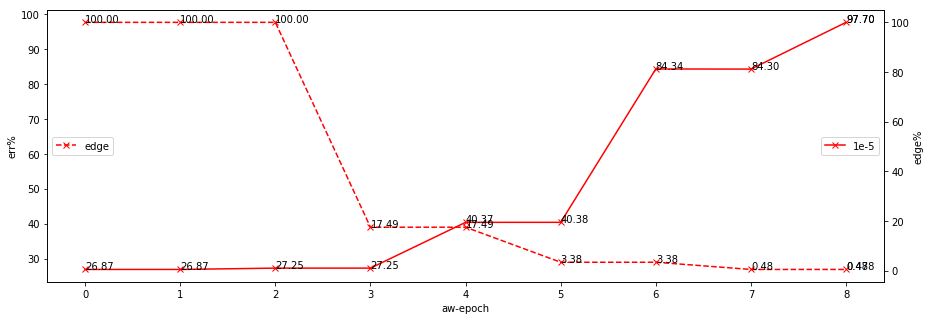

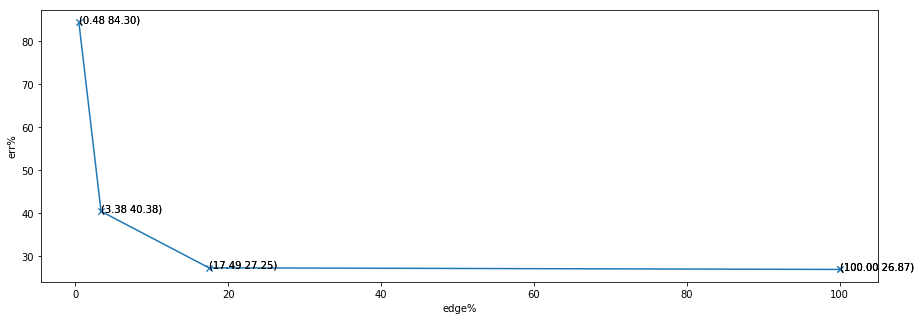

In [5]:
filelist=[
       'cifar100_vggG5_ard_load_vibnet5-history.ckpt',
]

legendlist=[
    '1e-5',
]

colorlist=[
    [1,0,0],
]

import matplotlib.pyplot
import torch
import numpy

fig,ax=matplotlib.pyplot.subplots(figsize=(15,5))
ax.set_ylabel('err%' )
ax.set_xlabel('aw-epoch')
#ax.set_ylim([0,10])
#ax.set_xlim([0,10])

for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    history=torch.load(ckptfile)
    y=history[0]
    lline=ax.plot(y ,'x-',color=colorlist[idd])
    
matplotlib.pyplot.legend(legendlist,loc=3) 
#ax.legend(['err',],loc=3)

for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    history=torch.load(ckptfile)
    y=history[0]
    x=len(y)-1
    lline=ax.plot(x,y[x],color=colorlist[idd])
    ax.annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))
    for x in range(len(y)):
        ax.annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))
        
    
    
matplotlib.pyplot.legend(legendlist,loc=5) 
#ax.legend(['err',],loc=3)


axR=ax.twinx()
axR.set_ylabel('edge%' )  

for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    history=torch.load(ckptfile)
    y=history[1]
    lline=axR.plot(y ,'x--',color=colorlist[idd])
    
for idd in range(len(filelist)):
    ckptfile=filelist[idd]
    history=torch.load(ckptfile)
    y=history[1]
    x=len(y)-1
    lline=axR.plot(x,y[x],color=colorlist[idd])
    axR.annotate( '{:.3f}'.format(y[x]),xy=(x,y[x]))
    for x in range(len(y)):
        axR.annotate( '{:.2f}'.format(y[x]),xy=(x,y[x]))
    
    
axR.legend(['edge',],loc=6)
#axR.set_ylim([])

def firstErrGivenEdge(preErr,etotalpercent,givenEdge):
    epoch,err,edge=-1,100,100
    for i in range(len(preErr)):
        if etotalpercent[i]<=givenEdge:
            epoch=i
            err=preErr[i]
            edge=etotalpercent[i]
            break
    return epoch,err,edge
import numpy

fig,ax=matplotlib.pyplot.subplots(figsize=(15,5))
errhistory=history[0]
edgehistory=history[1]
errlist=[]
edgelist=[]
rangeedge=edgehistory.copy()
rangeedge.sort()
for edgetmp in rangeedge:#numpy.arange(0,101,0.01):
    epoch,err,edge=firstErrGivenEdge(errhistory,edgehistory,edgetmp)
    if epoch>-1:
        errlist.append(err)
        edgelist.append(edge)
ax.plot(edgelist,errlist,'x-')
ax.set_xlabel('edge%')
ax.set_ylabel('err%')
#ax.set_ylim([0,10])
for tmpid in range(len(errlist)):
    x=edgelist[tmpid]
    y=errlist[tmpid]
    ax.annotate( '({:.2f} {:.2f})'.format(x,y),xy=(x,y))

In [6]:
def convlinear_flop_100G5(leftcovnode,leftlinearnode):
    input_mapsize=[32,32,16,16,8,8,8,8,4,4,4,4,2,2,2,2]
    flop=0
    for layer in range(1,17):
        flop+=leftcovnode[layer-1]*leftcovnode[layer]*9*input_mapsize[layer-1]*input_mapsize[layer-1]
    for layer in range(1,2):
        flop+=leftlinearnode[layer-1]*leftlinearnode[layer]
    return flop
   
leftcovnode=[3,64,64,128,128,256,256,256,256,512,512,512,512,512,512,512,512]
leftlinearnode=[512,100]
fullFlop=convlinear_flop_100G5(leftcovnode,leftlinearnode)
print(fullFlop)

398182400


In [7]:
fullModelWeightNumber=20070080

In [11]:
errlist=history[0]
edgeratiolist=history[1]
covlist=history[2]
linearlist=history[3]
for epoch in range(len(covlist)):
    err=errlist[epoch]
    leftcovnode=covlist[epoch]
    leftlinearnode=linearlist[epoch]
    edgeratio=edgeratiolist[epoch]
    flop=convlinear_flop_100G5(leftcovnode,leftlinearnode)
    
    print('epoch_{:}:'.format(int(epoch/2)),end=' ')
    for n in range(len(leftcovnode)-1):
        print(leftcovnode[n],end='-')
    print(leftcovnode[-1],end=' ')
    for n in range(len(leftlinearnode)-1):
        print(leftlinearnode[n],end='-')
    print(leftlinearnode[-1],end=' ')
    print(' err={:.2f}% edge={:.3e} {:.2f}% flop={:.3e} {:.2f}%'.format(err,edgeratio*fullModelWeightNumber/100,edgeratio,flop , flop*100/fullFlop ))
    print()

epoch_0: 3-64-64-128-128-256-256-256-256-512-512-512-512-512-512-512-512 512-100  err=26.87% edge=2.007e+07 100.00% flop=3.982e+08 100.00%

epoch_0: 3-64-64-128-128-256-256-256-256-512-512-512-512-512-512-512-512 512-100  err=26.87% edge=2.007e+07 100.00% flop=3.982e+08 100.00%

epoch_1: 3-64-64-128-128-256-256-256-256-512-512-512-512-512-512-512-512 512-100  err=27.25% edge=2.007e+07 100.00% flop=3.982e+08 100.00%

epoch_1: 3-56-64-127-127-251-250-253-254-203-94-24-21-23-52-163-324 324-100  err=27.25% edge=3.511e+06 17.49% flop=2.313e+08 58.09%

epoch_2: 3-56-64-127-127-251-250-253-254-203-94-24-21-23-52-163-324 324-100  err=40.37% edge=3.511e+06 17.49% flop=2.313e+08 58.09%

epoch_2: 3-51-62-104-116-184-76-32-20-11-3-4-6-11-26-65-145 302-100  err=40.38% edge=6.780e+05 3.38% flop=9.581e+07 24.06%

epoch_3: 3-51-62-104-116-184-76-32-20-11-3-4-6-11-26-65-145 302-100  err=84.34% edge=6.780e+05 3.38% flop=9.581e+07 24.06%

epoch_3: 3-50-46-52-34-8-4-3-3-3-3-4-5-6-5-11-97 225-100  err=84.3